# Testing Dask with Mongo

Install docker, pymongo and dask first as dependencies

In [1]:
%pip install docker pymongo dask[complete] graphviz

You should consider upgrading via the '/home/rachelle2/.pyenv/versions/3.6.9/envs/laputa-3.6/bin/python3.6 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Set Up Mongo Docker Image
NOTE : this reuses the other notebook's same configuration for simplicity's sake

In [1]:
import os
import docker

docker_client = docker.from_env()

mongo_container = docker_client.containers.run(
    'mongo:latest',
    detach=True,
    name='mongo-data-prep',
    remove=True,
    ports={'27017/tcp': 27018},
    mem_limit='512M',
    volumes={
        os.path.join(os.getcwd(), 'db'): {'bind': '/data/db', 'mode': 'rw'},
        os.path.join(os.getcwd(), 'mongo.conf'): {'bind': '/etc/mongo.conf', 'mode': 'ro'}
    }
)

APIError: 409 Client Error: Conflict ("Conflict. The container name "/mongo-data-prep" is already in use by container "57d1fbb8f13d5559c2ba2bb7f8a7c3f6d4d712f4a7d50481a1665c3cdcdc4471". You have to remove (or rename) that container to be able to reuse that name.")

Add logging

In [3]:
mongo_container.logs()

NameError: name 'mongo_container' is not defined

In [2]:
mongo_container.stop()

NameError: name 'mongo_container' is not defined

# Set Up Mongo Client

Get the Mongo client and add a database named `prep-test` to it.

In [3]:
from pymongo import InsertOne, MongoClient
mongo_client = MongoClient('127.0.0.1', 27018)
db = mongo_client['prep-test']

In [4]:
mongo_client.server_info()

{'version': '4.2.5',
 'gitVersion': '2261279b51ea13df08ae708ff278f0679c59dc32',
 'modules': [],
 'allocator': 'tcmalloc',
 'javascriptEngine': 'mozjs',
 'sysInfo': 'deprecated',
 'versionArray': [4, 2, 5, 0],
 'openssl': {'running': 'OpenSSL 1.1.1  11 Sep 2018',
  'compiled': 'OpenSSL 1.1.1  11 Sep 2018'},
 'buildEnvironment': {'distmod': 'ubuntu1804',
  'distarch': 'x86_64',
  'cc': '/opt/mongodbtoolchain/v3/bin/gcc: gcc (GCC) 8.2.0',
  'ccflags': '-fno-omit-frame-pointer -fno-strict-aliasing -ggdb -pthread -Wall -Wsign-compare -Wno-unknown-pragmas -Winvalid-pch -Werror -O2 -Wno-unused-local-typedefs -Wno-unused-function -Wno-deprecated-declarations -Wno-unused-const-variable -Wno-unused-but-set-variable -Wno-missing-braces -fstack-protector-strong -fno-builtin-memcmp',
  'cxx': '/opt/mongodbtoolchain/v3/bin/g++: g++ (GCC) 8.2.0',
  'cxxflags': '-Woverloaded-virtual -Wno-maybe-uninitialized -fsized-deallocation -std=c++17',
  'linkflags': '-pthread -Wl,-z,now -rdynamic -Wl,--fatal-war

# Generate Random Data

We also check here if anything has been inserted into the Mongo database

NOTE: The name of the collection is `test_data`

In [5]:
import random

COLLECTION_NAME = 'test_data'
MAX_NUM_OF_DOCS = 1001

# Template of doc looks like { 'color' : 'purple', 'number' : 1, 'random' : 'PUPPIES' }
# Lists and number ranged to populate the random documents
list_of_random = ['PUPPIES', 'CHOCOLATE', 'SONATA', 'RATATOUILLE', 'HYPERDRIVE', 'RIFIFI']
list_of_colors = ['black', 'orange', 'purple', 'red', 'blue']
NUM_CAP = 101

def generate_doc():
    return {
        'color' : random.choice(list_of_colors),
        'number' : random.choice(range(NUM_CAP)),
        'random' : random.choice(list_of_random)
    }

def insert_doc():
    return InsertOne(generate_doc())
      
def check_for_data():
    return db[COLLECTION_NAME].find_one()

def load_data_into_db(max_num_of_docs):
    db[COLLECTION_NAME].drop()
    db[COLLECTION_NAME].bulk_write([insert_doc() for i in range(max_num_of_docs)])

load_data_into_db(MAX_NUM_OF_DOCS)
check_for_data()

{'_id': ObjectId('5ebbb0a928877afadc15d1cc'),
 'color': 'orange',
 'number': 73,
 'random': 'RATATOUILLE'}

# Mongo Pipeline
These functions are to emulate a Mongo pipeline

 Note: we never want the data to leave mongo's server. Not even to reach our python kernel!
 So:
 - we use `$out` to directly tell mongo to write in a collection
 - we don't pass data across functions, only collection names


In [6]:
def find_all_purple_lte_50(col):
    col_name = 'purple'
    pipeline = [
        { '$match': { 'color': 'purple', 'number': { '$lte': 50 } } },
        { '$out' : col_name }
    ]
    db[col].aggregate(pipeline)
    return col_name

def find_all_orange_gt_50(col):
    col_name = 'orange'
    pipeline = [
        { '$match' : { 'color' : 'orange', 'number' : { '$gt' : 50} } },
        { '$out' : col_name }
    ]
    db[col].aggregate(pipeline)
    return col_name
    
def append_col_stages(col):
    return [
        {
            "$group": {
              "_id": None,
              "_vqbPipelineInline": {
                "$push": "$$ROOT"
              }
            }
        },
        {
            "$lookup": {
              "from": col,
              "pipeline": [
                {
                  "$match": {}
                },
                {
                  "$project": {
                    "_id": 0
                  }
                }
              ],
              "as": "_vqbPipelineToAppend_0"
            }
        },
        {
            "$project": {
              "_vqbPipelinesUnion": {
                "$concatArrays": [
                  "$_vqbPipelineInline",
                  "$_vqbPipelineToAppend_0"
                ]
              }
            }
        },
        {
            "$unwind": "$_vqbPipelinesUnion"
        },
        {
            "$replaceRoot": {
              "newRoot": "$_vqbPipelinesUnion"
            }
        },
    ]
    
def group_orange_purple(col1, col2):
    col_name = 'result'
    pipeline = [
        {
            '$match' : { 'color' : col1 }
        },
        *append_col_stages(col2)
        ,
        {
            '$out' : col_name
        }
    ]
    db.purple.aggregate(pipeline)
    return col_name

col_1 = find_all_purple_lte_50(COLLECTION_NAME)
col_2 = find_all_orange_gt_50(COLLECTION_NAME)
group_orange_purple(col_1, col_2)

list(db.result.find({}))

[{'_id': ObjectId('5ebbb0a928877afadc15d1db'),
  'color': 'purple',
  'number': 1,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1e3'),
  'color': 'purple',
  'number': 8,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1e4'),
  'color': 'purple',
  'number': 50,
  'random': 'SONATA'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1f0'),
  'color': 'purple',
  'number': 21,
  'random': 'RATATOUILLE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1f7'),
  'color': 'purple',
  'number': 40,
  'random': 'SONATA'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1fe'),
  'color': 'purple',
  'number': 20,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d21e'),
  'color': 'purple',
  'number': 30,
  'random': 'PUPPIES'},
 {'_id': ObjectId('5ebbb0a928877afadc15d227'),
  'color': 'purple',
  'number': 23,
  'random': 'HYPERDRIVE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d229'),
  'color': 'purple',
  'number': 14,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId

Drop the tested collections to wipe them clean

In [7]:
db.purple.drop()
db.orange.drop()
db.result.drop()

# Set up Dask as task runner

In [8]:
dsk = {
    'input1' : COLLECTION_NAME,
    'output1' : (find_all_purple_lte_50, 'input1'),
    'output2' : (find_all_orange_gt_50, 'input1'),
    'output3' : (group_orange_purple, 'output1', 'output2')
}

import dask and use it to do stuff

In [9]:
import dask

dask.get(dsk, ['output3'])
list(db.result.find({}))

[{'_id': ObjectId('5ebbb0a928877afadc15d1db'),
  'color': 'purple',
  'number': 1,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1e3'),
  'color': 'purple',
  'number': 8,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1e4'),
  'color': 'purple',
  'number': 50,
  'random': 'SONATA'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1f0'),
  'color': 'purple',
  'number': 21,
  'random': 'RATATOUILLE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1f7'),
  'color': 'purple',
  'number': 40,
  'random': 'SONATA'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1fe'),
  'color': 'purple',
  'number': 20,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d21e'),
  'color': 'purple',
  'number': 30,
  'random': 'PUPPIES'},
 {'_id': ObjectId('5ebbb0a928877afadc15d227'),
  'color': 'purple',
  'number': 23,
  'random': 'HYPERDRIVE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d229'),
  'color': 'purple',
  'number': 14,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId

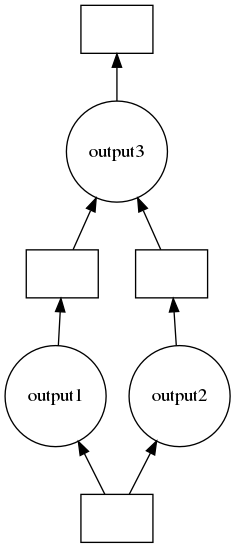

In [10]:
dask.visualize(dsk)

## A configurable MONGO_PIPELINE

Let's express what we want in a the declarative form we expect:

In [28]:
# This is all the already loaded domains in our databse
loaded_domains = [COLLECTION_NAME]

# This the list of new domains we want to create:
MONGO_PIPELINE = [
    {
        'output_domain': 'purple',
        'query': [
            { '$match': { 'domain': COLLECTION_NAME, 'color': 'purple', 'number': { '$lte': 50 } } },
        ]
    },
    {
        'output_domain': 'orange',
        'query': [
            { '$match' : { 'domain': COLLECTION_NAME, 'color' : 'orange', 'number' : { '$gt' : 50} } },
        ]
    },
    {
        'output_domain': 'result',
        'query': [
            {
            '$match' : { 'domain': 'purple', 'color' : 'purple' }
            },
            *append_col_stages('orange')
            ,
        ]
    },
]

To be able to recreate the `dsk` we need to:
- extract the input collections for each query
- add the `$out` stage for each query

### Extracting input_domains

We already have a nice function to do this, thanks to the work on permissions: https://github.com/ToucanToco/laputa/blob/master/laputa/common/utils/query_utils.py

In [12]:
# From laputa.common.utils.query_utils
from typing import List

def get_query_domain(query, domains=None):
    if domains is None:
        domains = []
    if isinstance(query, dict):
        for k, v in query.items():
            if k == 'domain':
                domains.append(v)
            elif k == '$match' and isinstance(v, dict) or isinstance(v, list):
                get_query_domain(v, domains)
    elif isinstance(query, list):
        for x in query:
            if isinstance(x, (list, dict)):
                get_query_domain(x, domains)
    res = set(domains)
    if len(res) == 1:
        return res.pop()
    else:
        raise InvalidDomain(f'Found more than one domain (or none) for query {query}: {res}')

        
class InvalidDomain(Exception):
    """ Raised when there is not exactly one domain in the query"""

    
def get_lookup_domain(lookup):
    """Extract the from value from a $lookup"""
    if isinstance(lookup, dict) and 'from' in lookup:
        return lookup['from']

        
def get_query_lookup_operators(query_operators: List[dict]) -> List[dict]:
    """ Returns the $lookups having a from and a pipeline childs """
    operators: List[dict] = []

    def crawl_operators(query_operators: List[dict], operators: List[dict], level: int):
        if not isinstance(query_operators, list):
            return
        for query_operator in query_operators:
            for k, v in query_operator.items():
                if k == '$lookup' and ('from' and 'pipeline') in v:
                    operators.append({k: v})
                    crawl_operators(v['pipeline'], operators, level + 1)

    crawl_operators(query_operators, operators, 0)
    return operators


def get_query_lookup_domains(query):
    """Iterate over each $match and $lookup."""
    domains = []
    operators = get_query_lookup_operators(query)

    for operator in operators:
        if '$lookup' in operator:
            domains.append(get_lookup_domain(operator['$lookup']))

    return [domain for domain in domains if domain]

In [13]:
def extract_input_domains(query):
    return [get_query_domain(query), *get_query_lookup_domains(query)]

[extract_input_domains(x['query']) for x in MONGO_PIPELINE]

[['test_data'], ['test_data'], ['purple', 'orange']]

### Adding `$out` stage 

In [14]:
import copy

def query_with_out_stage(mongo_pipe):
    query = copy.deepcopy(mongo_pipe['query'])
    
    # Also remove the domain here, it's a field that only exist in laputa:
    del query[0]['$match']['domain']
    
    query.append(
        {'$out': mongo_pipe['output_domain']}
    )
    return query

[query_with_out_stage(x) for x in MONGO_PIPELINE]

[[{'$match': {'color': 'purple', 'number': {'$lte': 50}}}, {'$out': 'purple'}],
 [{'$match': {'color': 'orange', 'number': {'$gt': 50}}}, {'$out': 'orange'}],
 [{'$match': {'color': 'purple'}},
  {'$group': {'_id': None, '_vqbPipelineInline': {'$push': '$$ROOT'}}},
  {'$lookup': {'from': 'orange',
    'pipeline': [{'$match': {}}, {'$project': {'_id': 0}}],
    'as': '_vqbPipelineToAppend_0'}},
  {'$project': {'_vqbPipelinesUnion': {'$concatArrays': ['$_vqbPipelineInline',
      '$_vqbPipelineToAppend_0']}}},
  {'$unwind': '$_vqbPipelinesUnion'},
  {'$replaceRoot': {'newRoot': '$_vqbPipelinesUnion'}},
  {'$out': 'result'}]]

### Construction of the dask functions from queries 

The `dsk` needs functions to execute. Let's create a factory to create functions that will execute the aggregation:

In [15]:
def create_aggregation_executor(agg_query, output_domain):
    
    def execute_aggregation(*input_domains):
        print('INPUT', input_domains[0])
        print('COUNT', db[input_domains[0]].count_documents({}))
        print('EXECUTE', agg_query)
        print('OUTPUT', output_domain)
        db[input_domains[0]].aggregate(agg_query)
        print('RESULTS', db[output_domain].count_documents({}))
        return output_domain
    
    return execute_aggregation

### Constructing the dsk

In [16]:
aggregation_steps = [
    {
        'output_domain': x['output_domain'],
        'input_domains': extract_input_domains(x['query']),
        'executor': create_aggregation_executor(query_with_out_stage(x), x['output_domain']),
    } for x in MONGO_PIPELINE
]

In [25]:
"""
collection identifier in dask and the actual collection name should differ, otherwise we'll have
`{'col': 'col'}` in the dsk, which mean a loop!
"""
def id_col(col):
    return 'col:' + col

dsk = {
    # First let's add all of input_domains (we have only one here)
    id_col(COLLECTION_NAME): COLLECTION_NAME, 
    
    # Then our aggregations steps
    **{
        id_col(x['output_domain']): (x['executor'], *map(id_col, x['input_domains'])) for x in aggregation_steps
    }
}
dsk

{'col:test_data': 'test_data',
 'col:purple': (<function __main__.create_aggregation_executor.<locals>.execute_aggregation(*input_domains)>,
  'col:test_data'),
 'col:orange': (<function __main__.create_aggregation_executor.<locals>.execute_aggregation(*input_domains)>,
  'col:test_data'),
 'col:result': (<function __main__.create_aggregation_executor.<locals>.execute_aggregation(*input_domains)>,
  'col:purple',
  'col:orange')}

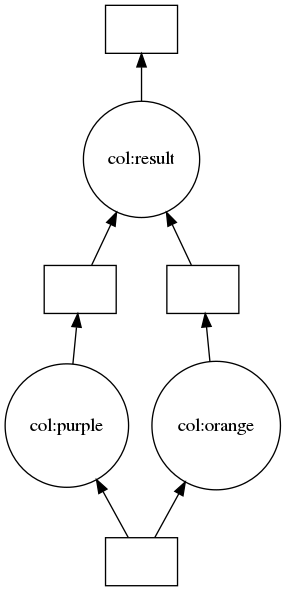

In [21]:
dask.visualize(dsk)

In [26]:
dask.get(dsk, [id_col('result')])

INPUT test_data
COUNT 1001
EXECUTE [{'$match': {'color': 'orange', 'number': {'$gt': 50}}}, {'$out': 'orange'}]
OUTPUT orange
RESULTS 109
INPUT test_data
COUNT 1001
EXECUTE [{'$match': {'color': 'purple', 'number': {'$lte': 50}}}, {'$out': 'purple'}]
OUTPUT purple
RESULTS 109
INPUT purple
COUNT 109
EXECUTE [{'$match': {'color': 'purple'}}, {'$group': {'_id': None, '_vqbPipelineInline': {'$push': '$$ROOT'}}}, {'$lookup': {'from': 'orange', 'pipeline': [{'$match': {}}, {'$project': {'_id': 0}}], 'as': '_vqbPipelineToAppend_0'}}, {'$project': {'_vqbPipelinesUnion': {'$concatArrays': ['$_vqbPipelineInline', '$_vqbPipelineToAppend_0']}}}, {'$unwind': '$_vqbPipelinesUnion'}, {'$replaceRoot': {'newRoot': '$_vqbPipelinesUnion'}}, {'$out': 'result'}]
OUTPUT result
RESULTS 218


('result',)

In [27]:
list(db.purple.find({}))

[{'_id': ObjectId('5ebbb0a928877afadc15d1db'),
  'color': 'purple',
  'number': 1,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1e3'),
  'color': 'purple',
  'number': 8,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1e4'),
  'color': 'purple',
  'number': 50,
  'random': 'SONATA'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1f0'),
  'color': 'purple',
  'number': 21,
  'random': 'RATATOUILLE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1f7'),
  'color': 'purple',
  'number': 40,
  'random': 'SONATA'},
 {'_id': ObjectId('5ebbb0a928877afadc15d1fe'),
  'color': 'purple',
  'number': 20,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d21e'),
  'color': 'purple',
  'number': 30,
  'random': 'PUPPIES'},
 {'_id': ObjectId('5ebbb0a928877afadc15d227'),
  'color': 'purple',
  'number': 23,
  'random': 'HYPERDRIVE'},
 {'_id': ObjectId('5ebbb0a928877afadc15d229'),
  'color': 'purple',
  'number': 14,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId